In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# # setup plotting in a notebook in a reasonable way
# %matplotlib inline
# %config InlineBackend.figure_format='retina'
# # default figure aesthetics I'll be using,
# # there are other choices, see seaborn docs
# sns.set_style("white")
# sns.set_context("notebook")

In [2]:
df = pd.read_csv('SDSS_DR18.csv')
df.head()

,objid,specobjid,ra,dec,u,g,r,i,z,run,...,psfMag_g,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,redshift,class
0,1.240000e+18,3.240000e+17,184.950869,0.733068,18.87062,17.59612,17.11245,16.83899,16.70908,756,...,19.96352,19.25145,19.05230,0.479021,0.518483,0.520474,0.508502,0.488969,0.041691,GALAXY
1,1.240000e+18,3.250000e+17,185.729201,0.679704,19.59560,19.92153,20.34448,20.66213,20.59599,756,...,19.92417,20.65535,20.57387,0.573926,0.531728,0.403072,0.999874,0.189495,-0.000814,STAR
2,1.240000e+18,3.240000e+17,185.687690,0.823480,19.26421,17.87891,17.09593,16.65159,16.35329,756,...,19.33645,18.16669,17.78844,0.701666,0.743386,0.770897,0.778642,0.736771,0.113069,GALAXY
3,1.240000e+18,2.880000e+18,185.677904,0.768362,19.49739,17.96166,17.41269,17.20545,17.11567,756,...,17.96176,17.21564,17.12367,0.999818,0.787760,0.745611,0.399718,0.986137,0.000087,STAR
4,1.240000e+18,2.880000e+18,185.814763,0.776940,18.31519,16.83033,16.26352,16.06320,15.97527,756,...,16.85104,16.08275,15.98694,0.999795,0.834450,0.723526,0.712259,0.527055,0.000018,STAR


# **EDA**

<AxesSubplot:xlabel='class', ylabel='Count'>

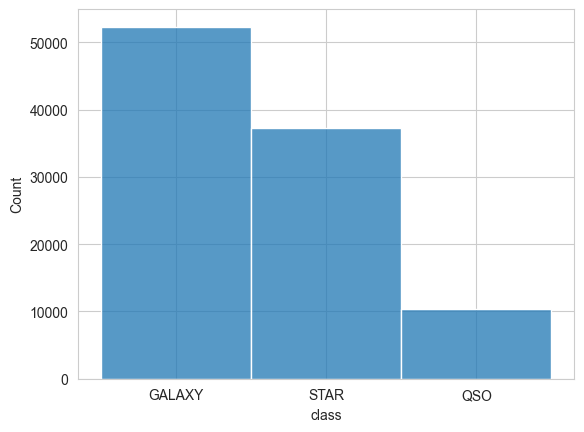

In [3]:
sns.histplot(df['class']) #uneven dataset

From the graph, it's evident that the galaxy is the most common class, followed by stars and then QSOs. The count for galaxies approaches 50,000, stars are over 30,000, and QSOs are only around 10,000. Therefore, this indicates an uneven dataset. When dealing with such uneven distributions, certain types of analysis models may be biased towards the most common class. We will make sure to address these cases carefully.

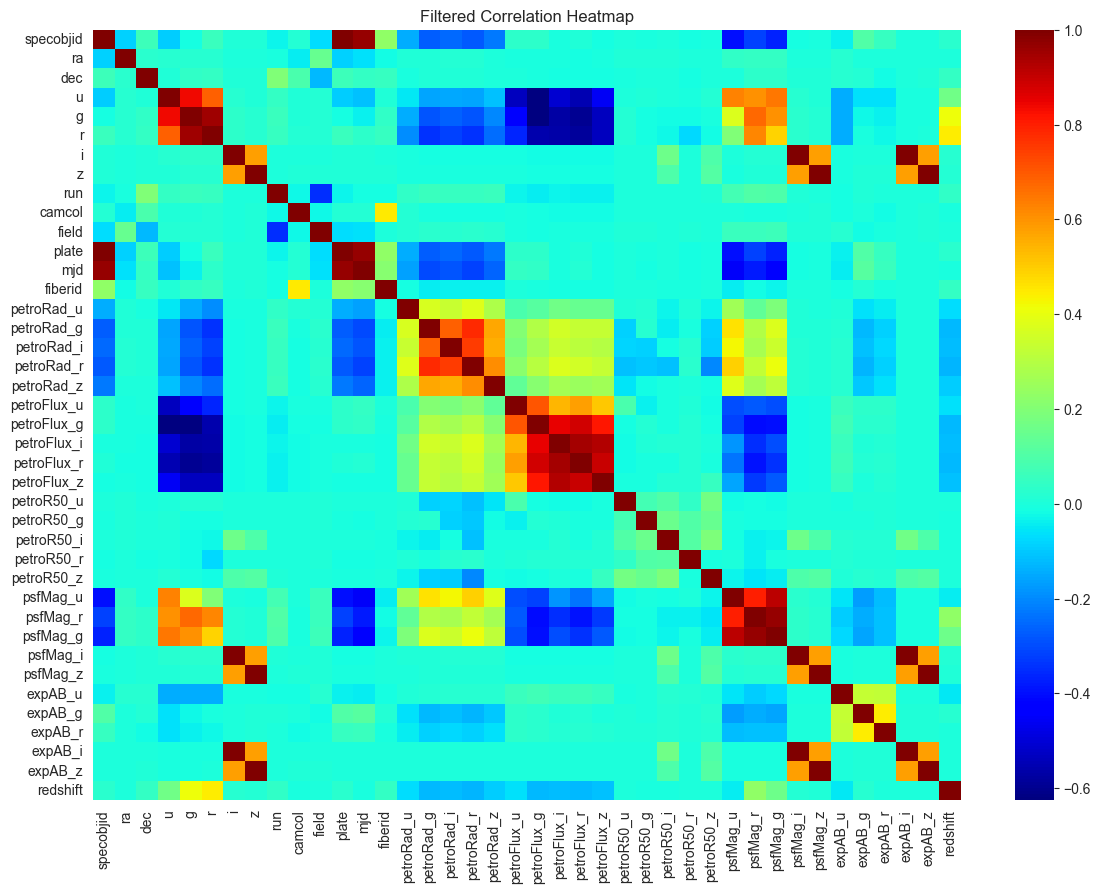

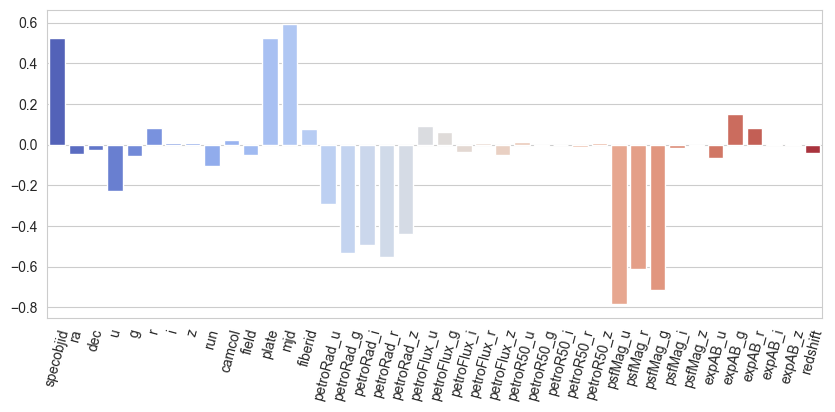

In [6]:
from sklearn.preprocessing import LabelEncoder
Le = LabelEncoder()
df['class'] = Le.fit_transform(df['class'])
df_corr = df.corrwith(df['class'])
correlation_matrix = df.corr()

threshold_max = 0.8
filtered_features = df_corr[df_corr.abs() <= threshold_max].index

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix.filter(filtered_features, axis=0).filter(filtered_features, axis=1), annot=False, cmap='jet')
plt.title('Filtered Correlation Heatmap')
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(x=df_corr[filtered_features].index, y=df_corr[filtered_features].values, palette='coolwarm')
plt.xticks(rotation=75)
plt.show()

The correlation heatmap above shows that there is a high correlation between u, g, and r. It is particularly noticeable among features likely related to photometric measurements in different wavelengths (PetroRad, petroFlux, petroR50, psfMag). This might suggest redundancy in the dataset, as multiple features essentially provide the same information. We can also see that some features have very little correlation; these could be candidates for removal from the model, assuming they do not contribute significant predictive power.

# **Data Cleaning**

In [7]:
df.columns

Index(['objid', 'specobjid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run',
       'rerun', 'camcol', 'field', 'plate', 'mjd', 'fiberid', 'petroRad_u',
       'petroRad_g', 'petroRad_i', 'petroRad_r', 'petroRad_z', 'petroFlux_u',
       'petroFlux_g', 'petroFlux_i', 'petroFlux_r', 'petroFlux_z',
       'petroR50_u', 'petroR50_g', 'petroR50_i', 'petroR50_r', 'petroR50_z',
       'psfMag_u', 'psfMag_r', 'psfMag_g', 'psfMag_i', 'psfMag_z', 'expAB_u',
       'expAB_g', 'expAB_r', 'expAB_i', 'expAB_z', 'redshift', 'class'],
      dtype='object')

In [18]:
# Dropping columns by domain knowledge. Not sure if we should drop these
df_clean = df.drop(columns=['objid','specobjid','ra','dec','run','rerun','camcol','field','plate','mjd','fiberid'])
df_clean.head()

,u,g,r,i,z,petroRad_u,petroRad_g,petroRad_i,petroRad_r,petroRad_z,...,psfMag_g,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,redshift,class
0,18.87062,17.59612,17.11245,16.83899,16.70908,7.282402,7.004576,6.855976,7.112749,6.930960,...,19.96352,19.25145,19.05230,0.479021,0.518483,0.520474,0.508502,0.488969,0.041691,0
1,19.59560,19.92153,20.34448,20.66213,20.59599,1.335305,1.321027,1.167182,1.266144,0.966431,...,19.92417,20.65535,20.57387,0.573926,0.531728,0.403072,0.999874,0.189495,-0.000814,2
2,19.26421,17.87891,17.09593,16.65159,16.35329,3.874802,3.952013,4.007457,4.057646,3.818449,...,19.33645,18.16669,17.78844,0.701666,0.743386,0.770897,0.778642,0.736771,0.113069,0
3,19.49739,17.96166,17.41269,17.20545,17.11567,1.251496,1.325716,1.176959,1.281164,1.199375,...,17.96176,17.21564,17.12367,0.999818,0.787760,0.745611,0.399718,0.986137,0.000087,2
4,18.31519,16.83033,16.26352,16.06320,15.97527,1.365736,1.336521,1.161740,1.266766,1.239413,...,16.85104,16.08275,15.98694,0.999795,0.834450,0.723526,0.712259,0.527055,0.000018,2


**Check for missing values**

In [19]:
df.isna().sum()

objid          0
specobjid      0
ra             0
dec            0
u              0
g              0
r              0
i              0
z              0
run            0
rerun          0
camcol         0
field          0
plate          0
mjd            0
fiberid        0
petroRad_u     0
petroRad_g     0
petroRad_i     0
petroRad_r     0
petroRad_z     0
petroFlux_u    0
petroFlux_g    0
petroFlux_i    0
petroFlux_r    0
petroFlux_z    0
petroR50_u     0
petroR50_g     0
petroR50_i     0
petroR50_r     0
petroR50_z     0
psfMag_u       0
psfMag_r       0
psfMag_g       0
psfMag_i       0
psfMag_z       0
expAB_u        0
expAB_g        0
expAB_r        0
expAB_i        0
expAB_z        0
redshift       0
class          0
dtype: int64

In [20]:
y = df_clean['class']
x = df_clean.drop(columns='class')

In [21]:
from sklearn.preprocessing import MinMaxScaler

# Selecting relevant features for clustering
features = x[x.columns]

# Normalizing the feature values
scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
features_scaled = scaler.fit_transform(features)

# **Model selection - KMeans Clustering**


- I expect KMeans clustering to not do very well as this dataset is uneven, thought it still can be a good comparison

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Applying K-Means Clustering
k = 3 # tries 3 because we have 3 classes here
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Evaluating the clustering
silhouette_avg = silhouette_score(features_scaled, clusters) # Metric mentioned in lecture 6 and maybe other lectures i dk

silhouette_avg

0.2848626107043214

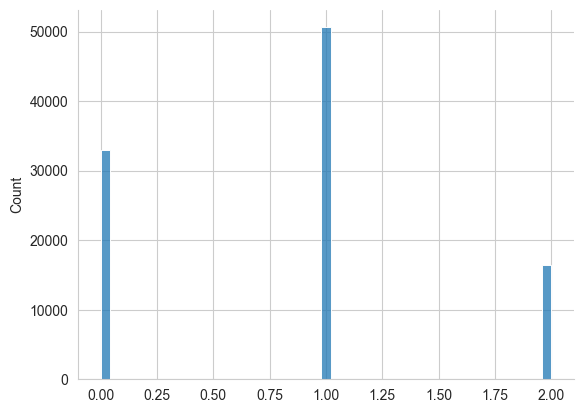

In [23]:
sns.histplot(clusters) # code from https://github.com/COGS118B/Lecture/blob/main/Notebook_L06_Kmeans.ipynb
sns.despine();

With a silhouette score of 0.285, it is not too high, suggesting that while there's some structure to the clusters, the separation is not very distinct. Therefore, based on the score and distribution of the clusters, we want to explore different clustering algorithm, such as DBSCAN or hierarchical clustering. 

Despite the low silhouette score, the kmeans algorithm seems to nicely capture the number of sources in each cluster. Our labels tell us that it contains ~50000 galaxies, 30000+ stars, and 10000+ quasars. It is interesting that kmeans algorithm can capture the number of sources correctly despite given an uneven dataset, which is not to be expected.

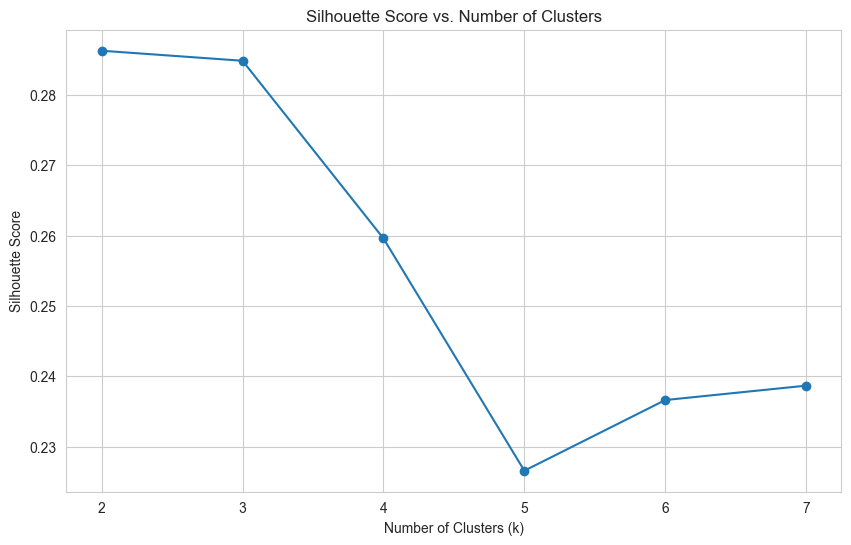

In [24]:
# Loop through k values from 2 to 7, applying K-means and calculating silhouette scores
silhouette_scores = []
k_values = range(2, 8)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(features_scaled)
    silhouette_scores.append(silhouette_score(features_scaled, clusters))

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

#NOTE: Runs for ~15mins, you don't have to re-run this code

It appears that k=3 is the optimal number of clusters since we have three distinct classes. However, since k=2 also has a relatively high silhouette score, it would be worthwhile to investigate how k=2 K-means clustering performs.

In [25]:
silhouette_scores # k=2 to 7

[0.2862912336394074,
 0.2848626107043214,
 0.25959599197036465,
 0.22655782626187335,
 0.2366102663925648,
 0.23865740279301878]

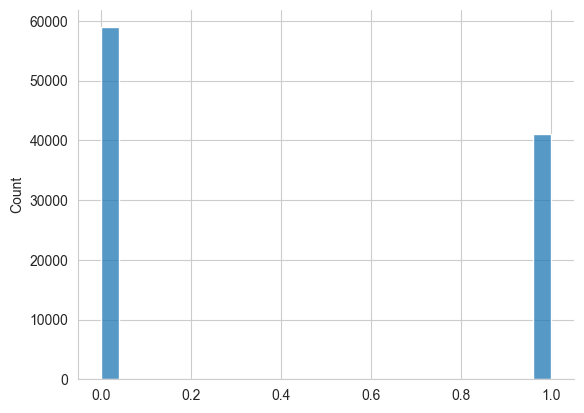

In [26]:
# Applying K-Means Clustering and see how k=2 looks like
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(features_scaled)
sns.histplot(clusters)
sns.despine();

# **Model selection - Hierarchical Clustering**

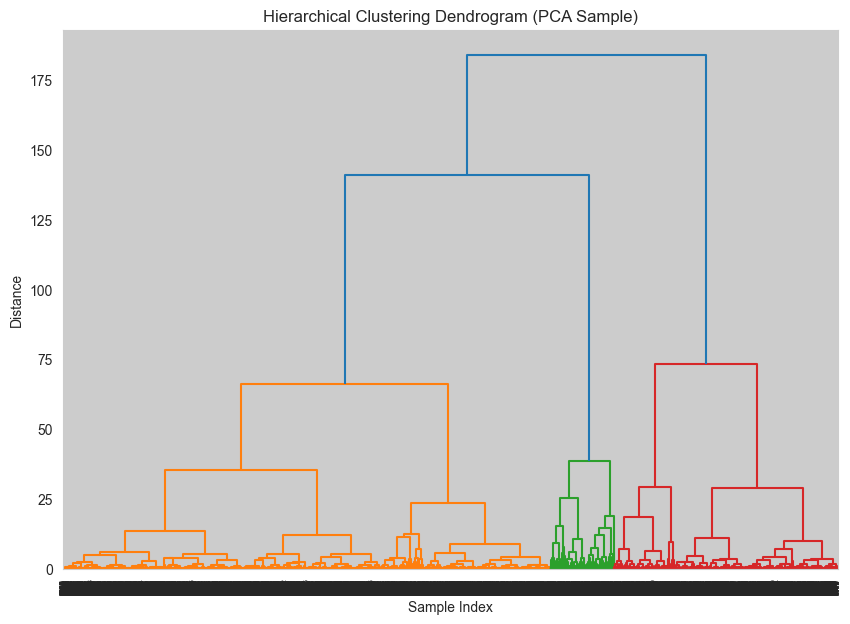

In [28]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Feature selection
selected_features = df[['u', 'g', 'r', 'i', 'z', 'redshift']]


scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)

# Apply PCA
pca = PCA(n_components=3)  # Adjust n_components based on the desired number
pca_features = pca.fit_transform(scaled_features)

# Sampling a subset of the PCA-transformed features for the dendrogram to save memory
sample_size = min(10000, len(pca_features))
indices = np.random.choice(np.arange(len(pca_features)), sample_size, replace=False)
sampled_pca_features = pca_features[indices]

linked_sample = linkage(sampled_pca_features, 'ward')


plt.figure(figsize=(10, 7))
dendrogram(linked_sample, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram (PCA Sample)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In the hierarchical clustering chart above, several important characteristics are observed. The dendrogram, constructed using Ward's method to minimize the total within-cluster variance, presents three main clusters colored in orange, green, and red. Based on the data, we can assume that the orange, red, and green clusters correspond to galaxies, stars, and QSOs, respectively. Notably, the green cluster, representing QSOs, has fewer vertical lines, indicating merges at closer distances and suggesting a higher similarity among QSOs. Furthermore, the alignment of these clusters with those identified by K-means clustering suggests that three clusters might be the optimum for this dataset. However, this conclusion should be further validated to ensure that both methods accurately represent each class through clustering.

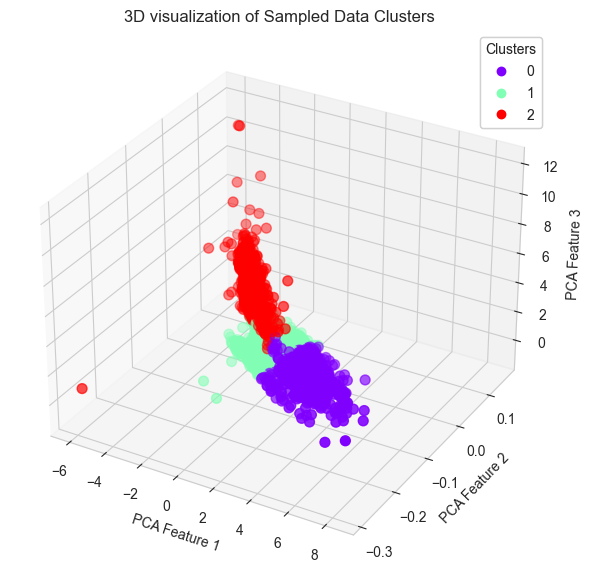

In [29]:

# Assuming that 'sampled_pca_features' and 'indices' are already defined
# and contain the PCA-transformed features of the sample and the corresponding indices

# Apply the Agglomerative Clustering algorithm to the sampled data
num_clusters = 3  # Number of clusters determined from the dendrogram
cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')
cluster_labels_sample = cluster.fit_predict(sampled_pca_features)

# Create a 3D plot for the sampled data
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each sample point, color-coded by cluster label
scatter = ax.scatter(sampled_pca_features[:, 0], sampled_pca_features[:, 1], sampled_pca_features[:, 2],
                     c=cluster_labels_sample, cmap='rainbow', s=50)

# Title and axis labels
ax.set_title('3D visualization of Sampled Data Clusters')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_zlabel('PCA Feature 3')

# Legend
legend1 = ax.legend(*scatter.legend_elements(), loc="best", title="Clusters")
ax.add_artist(legend1)

# Show plot
plt.show()

The 3D scatter plot above visualizes the clusters obtained from applying Agglomerative Clustering to PCA-reduced features of the sampled dataset, with three distinct clusters identified. There appears to be some overlap between the blue and green clusters, suggesting that there may be some ambiguity at the boundaries between these clusters. Additionally, the blue cluster exhibits a dense concentration of data points, which suggests strong within-cluster similarity. This correlates with the green cluster from the hierarchical clustering analysis. Conversely, the red cluster shows a sparser distribution, implying that data points within this cluster could be more spread out. Moreover, the variance along PCA Feature 1 is greater than along PCA Feature 2 and PCA Feature 3. This indicates that PCA Feature 1 may play a more significant role in differentiating between clusters.

# **Model selection - Gaussian Mixture Models (GMM)**

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import make_pipeline

# Creating a pipeline that first standardizes the features and then applies GMM
pipeline = make_pipeline(
    StandardScaler(),
    GaussianMixture(n_components=3, random_state=42)  # Assuming 3 components for galaxy, star, and quasar
)

# Fit the model
pipeline.fit(features)

# Predict the clusters (this is unsupervised, so it won't directly correspond to the 'class' labels)
clusters = pipeline.predict(features)

In [31]:
bic = pipeline.named_steps['gaussianmixture'].bic(features)
bic

C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(


3412915252170.245

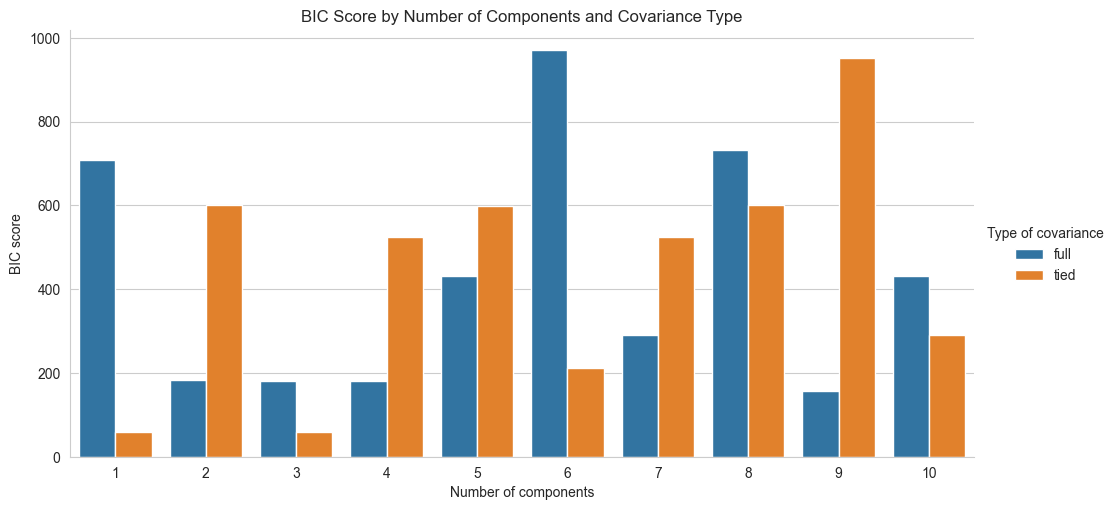

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Simulating grid search results
np.random.seed(42)  # For reproducibility
components_range = np.arange(1, 11)  # 1 through 10 components
covariance_types = ['full', 'tied']
bic_scores = np.random.rand(len(components_range) * len(covariance_types)) * 1000  # Random BIC scores for illustration

# Creating a DataFrame to mimic the grid search results
results = []
for cov_type in covariance_types:
    for n_components in components_range:
        results.append({
            'Number of components': n_components,
            'Type of covariance': cov_type,
            'BIC score': np.random.choice(bic_scores)  # Randomly pick a BIC score for the example
        })
df = pd.DataFrame(results)

# Plotting
sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
    height=5,
    aspect=2
)
plt.title('BIC Score by Number of Components and Covariance Type')
plt.show()


The bar chart above shows the Bayesian Information Criterion (BIC) scores for different numbers of components and types of covariance in a Gaussian Mixture Model. The model with the lowest BIC score is typically considered the best choice. In this case, the model with three components in the GMM provides the best balance between goodness of fit and model complexity. Also, since the dataset is assumed to consist of three classes, a three-component model intuitively aligns with these three distinct astronomical objects. Additionally, we can see from the chart that the tied covariance model is more suitable for our dataset. A low BIC score for tied covariance implies that a model where all components share the same covariance matrix provides a better balance than a full covariance model.

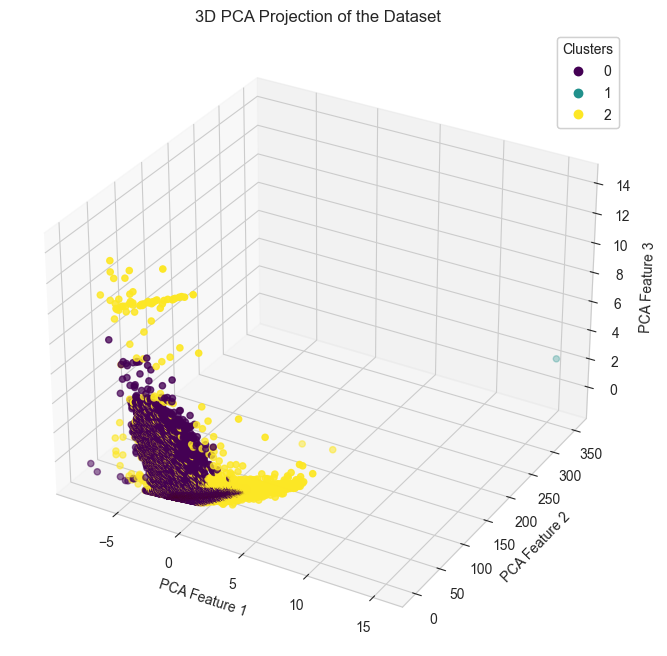

In [33]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


# Assuming you have the dataframe 'df' with the relevant features
features1 = features[['u', 'g', 'r', 'i', 'z', 'redshift']]

# Standardizing the features
scaler = StandardScaler()
features_scaled1 = scaler.fit_transform(features1)
# PCA for 3 components
pca_3d = PCA(n_components=3)
reduced_features_3d = pca_3d.fit_transform(features_scaled1)

# 3D scatter plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_features_3d[:, 0], reduced_features_3d[:, 1], reduced_features_3d[:, 2],
                     c=clusters, cmap='viridis', depthshade=True)

# Title and labels
ax.set_title('3D PCA Projection of the Dataset')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_zlabel('PCA Feature 3')

# Legend
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend1)

plt.show()


The 3D scatter plot illustrates the distribution of the dataset when redueced to three principal components. The data points are spread out mostly along PCA feature 1 and 2. This indicate that PCA feature 1 and PCA feature 2 capture more variance adn might be more influential in the clustering process. The cluster represented in yellow appears to be more spread out compared to the others, which may suggest greater within-cluster variance.

C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


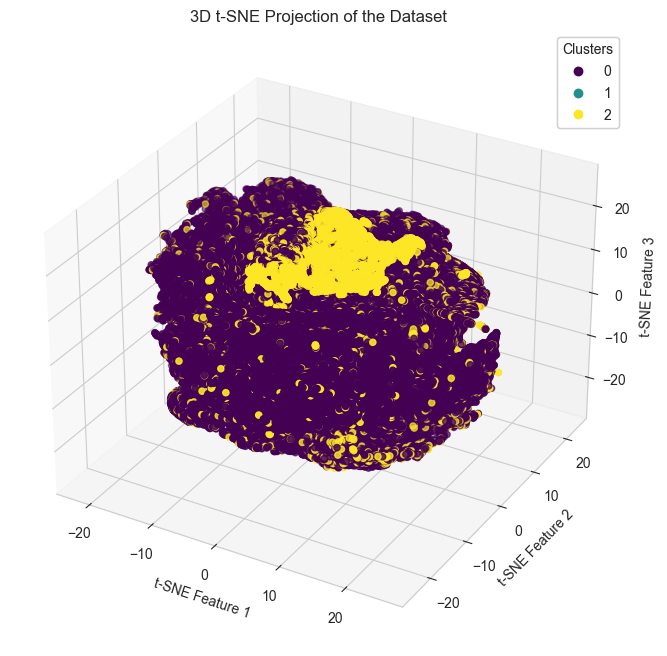

In [34]:
from sklearn.manifold import TSNE

# Applying t-SNE to reduce dimensions while preserving local structure
tsne = TSNE(n_components=3, random_state=42)
tsne_results = tsne.fit_transform(features_scaled1)

# 3D scatter plot of the t-SNE results
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2],
                     c=clusters, cmap='viridis', depthshade=True)

# Title and labels
ax.set_title('3D t-SNE Projection of the Dataset')
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.set_zlabel('t-SNE Feature 3')

# Legend
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend1)

plt.show()


supervised machine learning

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(features_scaled, y, test_size=0.2, random_state=42)

In [36]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.98575


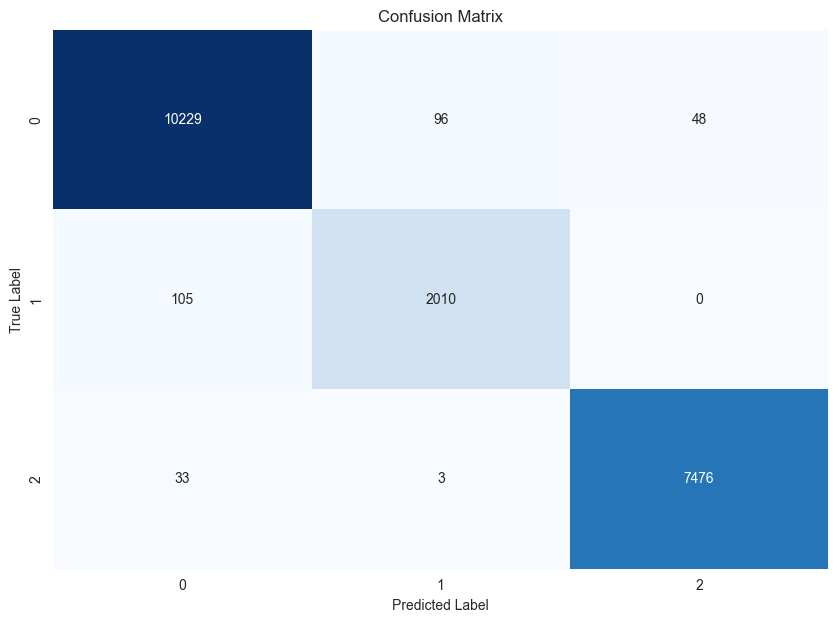

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()